# DL_3

## Loading Data

In [1]:
# mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np

# getting the paths for the data
input_data_path = '/content/drive/MyDrive/Data/MSc_DL/Input_Data.txt'
output_data_path = '/content/drive/MyDrive/Data/MSc_DL/Output_Data.txt'
WaterHeatermaxAgg_path = '/content/drive/MyDrive/Data/MSc_DL/WaterHeatermaxAgg.txt'
WaterHeatermaxApp_path = '/content/drive/MyDrive/Data/MSc_DL/WaterHeatermaxApp.txt'

# loading the data using numpy
input_data = np.loadtxt(input_data_path, delimiter=',')
output_data = np.loadtxt(output_data_path, delimiter=',')
agg_data = np.loadtxt(WaterHeatermaxAgg_path, delimiter=',')
app_data = np.loadtxt(WaterHeatermaxApp_path, delimiter=',')

In [3]:
# creating a directory for graphs and results
import os # for directory creation

def create_folder(dir_name):

  # Check if the folder exists
  if os.path.exists(os.getcwd() + '/' + dir_name):
    print("The folder "+ dir_name +" exists.")

  else:
    os.makedirs(dir_name)
    print("Folder "+ dir_name +" created succesfully.")

create_folder('result_files')
create_folder('result_files/model_files/simple_RNN/models')
create_folder('result_files/model_files/LSTM/models')
create_folder('result_files/model_files/GRU/models')

create_folder('result_files/model_files/simple_RNN/history')
create_folder('result_files/model_files/LSTM/history')
create_folder('result_files/model_files/GRU/history')

create_folder('result_files/model_files/simple_RNN/best_model')
create_folder('result_files/model_files/LSTM/best_model')
create_folder('result_files/model_files/GRU/best_model')

create_folder('result_files/model_files/simple_RNN/model_plots')
create_folder('result_files/model_files/LSTM/model_plots')
create_folder('result_files/model_files/GRU/model_plots')


create_folder('result_files/Plots')

Folder result_files created succesfully.
Folder result_files/model_files/simple_RNN/models created succesfully.
Folder result_files/model_files/LSTM/models created succesfully.
Folder result_files/model_files/GRU/models created succesfully.
Folder result_files/model_files/simple_RNN/history created succesfully.
Folder result_files/model_files/LSTM/history created succesfully.
Folder result_files/model_files/GRU/history created succesfully.
Folder result_files/model_files/simple_RNN/best_model created succesfully.
Folder result_files/model_files/LSTM/best_model created succesfully.
Folder result_files/model_files/GRU/best_model created succesfully.
Folder result_files/model_files/simple_RNN/model_plots created succesfully.
Folder result_files/model_files/LSTM/model_plots created succesfully.
Folder result_files/model_files/GRU/model_plots created succesfully.
Folder result_files/Plots created succesfully.


In [4]:
# showing the shapes of the data
input_data.shape, output_data.shape

((50000, 120), (50000, 120))

## Plotting Time Series

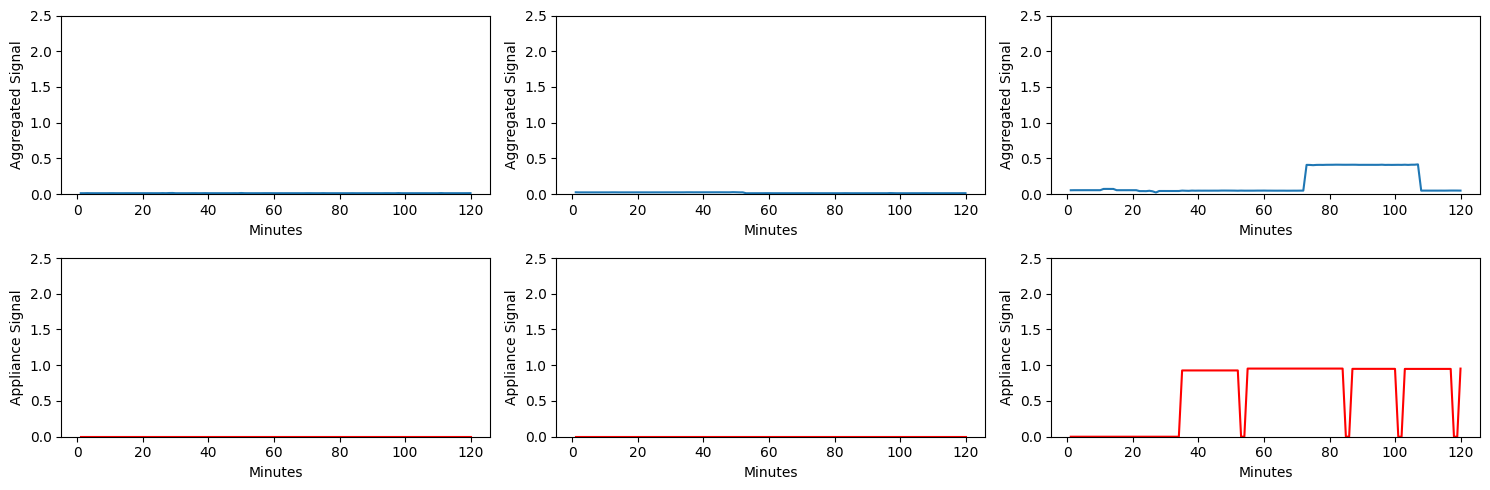

In [ ]:
import random
import matplotlib.pyplot as plt

# defining the number of plots
num_plots = 3

# defining the x axis range
x = [i for i in range(1, 121)]

# getting random time windows
inputs = [input_data[random.randint(0, input_data.shape[0]), :]
                          for _ in range(num_plots)]

outputs = [output_data[random.randint(0, output_data.shape[0]), :]
                          for _ in range(num_plots)]

# creating a figure with three subplots
fig, axs = plt.subplots(2, num_plots, figsize=(15, 5))

for i in range(axs.shape[1]):
  # plotting the first random timeseries
  axs[0, i].plot(x, inputs[i])
  axs[0, i].set_xlabel('Minutes')
  axs[0, i].set_ylabel('Aggregated Signal')
  axs[0, i].set_ylim(0, 2.5)

  axs[1, i].plot(x, outputs[i], color='red')
  axs[1, i].set_xlabel('Minutes')
  axs[1, i].set_ylabel('Appliance Signal')
  axs[1, i].set_ylim(0, 2.5)

# adjusting the spacing between subplots
plt.tight_layout()

# saving the figure
plt.savefig('result_files/Plots/random_seq_plots.png', bbox_inches='tight')
# showing the figure
plt.show()



## Data Split and Normalization

### Normalizing Data

In [5]:
# transforming the total consumption to kW
agg_data_kW = agg_data / 1000
app_data_kW = app_data / 1000


# Normalizing the data
norm_input_data = input_data / agg_data_kW
norm_output_data = output_data / app_data_kW

### Splitting into training, validation and testing set

In [6]:
# defining the train, validation and test sizes
train_size = int(0.7 * input_data.shape[0])
val_size = int(0.2 * input_data.shape[0])
test_size = int(0.1 * input_data.shape[0])

# showing the sizes
train_size, val_size, test_size

(35000, 10000, 5000)

In [7]:
# splitting the data based on the defined sizes

X_train = norm_input_data[0:train_size , :]
y_train = norm_output_data[0:train_size, :]

X_val = norm_input_data[train_size: train_size + val_size , :]
y_val = norm_output_data[train_size: train_size + val_size, :]

X_test = norm_input_data[train_size + val_size: train_size + val_size + test_size, :]
y_test = norm_output_data[train_size + val_size: train_size + val_size + test_size, :]

# showing the shapes of the train val and test sets
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(35000, 120) (35000, 120)
(10000, 120) (10000, 120)
(5000, 120) (5000, 120)


### Preprocessing for the models

In [8]:
# creating a function that reshapes the data into a 3D
# numpy array for the model (num_samples, sequence_length, features_dim)

def reshape_data(data, features_dim):

  num_samples = data.shape[0]
  sequence_length = data.shape[1]
  data = data.reshape(num_samples, sequence_length, features_dim)

  return data

features_dim = 1  # we have only one feature (power consumption)

X_train = reshape_data(X_train, features_dim)
X_val = reshape_data(X_val, features_dim)
X_test = reshape_data(X_test, features_dim)

y_train = reshape_data(y_train, features_dim)
y_val = reshape_data(y_val, features_dim)
y_test = reshape_data(y_test, features_dim)

# showing the shapes of the train val and test sets
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(35000, 120, 1) (35000, 120, 1)
(10000, 120, 1) (10000, 120, 1)
(5000, 120, 1) (5000, 120, 1)


## Helper Functions

### Learning Rate Decay Function

In [ ]:
# defining the learning rate decay schedule with exponential decay
def lr_decay(epoch, init_lr):
    decay_rate = init_lr / 5
    return init_lr * np.exp(-decay_rate * epoch)

### Create Model Function

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

import random

# function that creates a RNN (SimpleRNN, LSTM or GRU)
# model by specifying the parameters,

# NOTE: num_units has to be a list the size of num_layers
# The dropout_rate_list has various dropout rates one from which will
# be chosen randomly.
def create_model(Layer, num_layers, num_units,
                 sequence_length, features_dim,
                 output_size, init_lr,

                summary=False, dropout_prob=0.3, model_name='',
                dropout_rate_list=[0.2, 0.5, 0.7, 0.8]):

  model = Sequential()

  if model_name != '':
    # assigning a name to the model if
    # parameter model_name has been given a value
    model._name = model_name

  # setting this to be true if more than one layers are created
  return_sequences = True

  # adding layers
  for i in range(num_layers):

    # if the last layer is created then don't return a sequence
    if i + 1 == num_layers:
      return_sequence = False

    model.add(Layer(units=num_units[i],
                        input_shape=(sequence_length, features_dim),
                        return_sequences=return_sequences))

    # adding a dropout layer with a probability of dropout_prob
    if random.random() < dropout_prob:
      model.add(Dropout(random.choice(dropout_rate_list)))

  # adding a dense layer for output prediction
  model.add(Dense(units=output_size))

  # creating an Adam optimizer object
  optimizer = Adam(learning_rate=init_lr)

  # compiling and training the model
  model.compile(loss='mean_squared_error', optimizer=optimizer)

  if summary == True:
    model.summary()

  return model

### Create Models Function

In [ ]:
# creates models with as many configurations as defined
def create_models(Layer, num_configs, num_layers_list, num_units_list, init_lr_list,
                  model_type_name='Model'):

  models = [] # where all models will be stored

  for i in range(num_configs):

    # choosing number of layers
    num_layers = random.choice(num_layers_list)

    # choosing the number of units for each layer
    num_units = [random.choice(num_units_list) for _ in range(num_layers)]

    # choosing learning_rate form lr_list
    init_lr = random.choice(init_lr_list)

    # creating and adding model to the models list
    model = create_model(Layer, num_layers,
                       num_units, sequence_length,
                       features_dim, output_size, init_lr,
                       model_name = f'{model_type_name}_{i}', summary=True)

    models.append(model)

  return models

### Train Models Function

In [ ]:
# in order to find the best model faster
# the training data will be sampled and
# then the best model will be trained on all the
# training data

# defining the number of samples
num_samples = 10000

# getting the length of X_train
data_length = len(X_train)

# generating random indices
indices = np.random.choice(data_length, size=num_samples, replace=False)

# sampling the data using the generated indices
sampled_X_train = X_train[indices]
sampled_y_train = y_train[indices]

print(f'Sampled X_train shape: {sampled_X_train.shape}')
print(f'Sampled y_train shape: {sampled_y_train.shape}')


Sampled X_train shape: (10000, 120, 1)
Sampled y_train shape: (10000, 120, 1)


In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


# trains models and returns the best model on validation data
def train_models(models, epochs_list, batch_size_list, lr_decay, model_type):


  # creating the EarlyStopping callback with patience for 5 epochs
  early_stopping = EarlyStopping(monitor='val_loss', patience=5)

  hist_list = []
  # training the models
  for model in models:

    # choosing random number of epochs from the list
    epochs = random.choice(epochs_list)

    # choosing random number of batch_size from the list
    batch_size = random.choice(batch_size_list)


    # creating a ModelCheckpoint callback to get the model epoch with the lowest
    # validateion error
    checkpoint = ModelCheckpoint(
      filepath=f'result_files/model_files/{model_type}/models/best_{model.name}.h5',
                                 monitor='val_loss',
                                 save_best_only=True)


    # defining the learning rate scheduler for decaying the lr
    lr_scheduler = LearningRateScheduler(lr_decay, verbose=1)


    # training the model on the sampled X_train and y_train
    print(f'\nTraining {model.name} \n')
    print(f'Epochs = {epochs}')
    print(f'Batch Size = {batch_size}')
    print(f'Initial Learning Rate = {model.optimizer.lr.numpy()}\n')

    history = model.fit(sampled_X_train, sampled_y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=1,
                        callbacks=[early_stopping, checkpoint, lr_scheduler],
                        validation_data=(X_val, y_val))

    # appending training history
    hist_list.append(history)

  return models, hist_list


### Function for Training the Best Model

In [ ]:
# function to train the best model
def best_model_train(model, epochs, batch_size, model_type, model_name):

  # creating the EarlyStopping callback with patience for 5 epochs
  early_stopping = EarlyStopping(monitor='val_loss', patience=5)

  # creating a ModelCheckpoint callback to get the model epoch with the lowest
  # validateion error
  checkpoint = ModelCheckpoint(
                filepath=f'result_files/model_files/{model_type}/best_model/{model_name}.h5',
                monitor='val_loss',
                save_best_only=True)

  # defining the learning rate scheduler for decaying the lr
  lr_scheduler = LearningRateScheduler(lr_decay, verbose=1)

  # training the model on the sampled X_train and y_train
  print(f'\nTraining {model_name} \n')
  print(f'Epochs = {epochs}')
  print(f'Batch Size = {batch_size}')
  print(f'Initial Learning Rate = {model.optimizer.lr.numpy()}\n')

  history = model.fit(X_train, y_train,
                         epochs=epochs,
                         batch_size=batch_size,
                         verbose=1,
                         callbacks=[early_stopping, checkpoint, lr_scheduler],
                         validation_data=(X_val, y_val))

  # saving the training history
  with open(f'result_files/model_files/{model_type}/best_model/history_{model.name}.pickle', 'wb') as file:
      pickle.dump(history.history, file)

  return model, history



### Functions for Saving and Loading the History of the Models

In [ ]:
import pickle
from keras.models import load_model

def save_history(models, hist_list, model_type):
  for i in range(len(models)):

    history = hist_list[i]
    model = models[i]

    # saving the training history
    with open(f'result_files/model_files/{model_type}/history/history_{model.name}.pickle', 'wb') as file:
        pickle.dump(history.history, file)


def load_model_history(model_type, model_number):

  # loading the model
  loaded_model = load_model(f'result_files/model_files/{model_type}/models/best_{model_type}_{model_number}.h5')

  # loading the history
  with open(f'result_files/model_files/{model_type}/history/history_{model_type}_{model_number}.pickle', 'rb') as file:
      loaded_history = pickle.load(file)

  return loaded_model, loaded_history


### Clone Model Function

In [ ]:
import keras

def clone(model):

  # creating an untrained replica of the best model
  clone = keras.models.clone_model(model)
  clone.build(model.input_shape)
  clone.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')
  clone.summary()

  return clone

### Best Model Picker Function

In [ ]:
def best_model(models):
  # getting the index of the model with
  # the minimum validation loss in all training
  idx = np.argmin([min(model.history.history['val_loss']) for model in models])

  # extracting the model from the list of models
  return models[idx]

### Evaluating and Plotting Results Function

In [59]:
from sklearn.metrics import mean_squared_error, max_error
import matplotlib.pyplot as plt

def evaluate(y_true, y_pred, set_type='', model_type=''):

  # lists that will contain the values
  mse_list = []
  rmse_list = []
  max_err_list = []

  # computing the metrics and plotting them for
  # every row
  for i in range(len(y_true)):

    # computing the metrics
    mse = mean_squared_error(y_true[i], y_pred[i])
    rmse = mean_squared_error(y_true[i], y_pred[i], squared=False)
    max_err = max_error(y_true[i], y_pred[i])

    # appending them to the corresponding lists
    mse_list.append(mse)
    rmse_list.append(rmse)
    max_err_list.append(max_err)

  plt.title(f'Mean Squared Error {set_type}')
  plt.scatter([i for i in range(len(mse_list))], mse_list)
  plt.ylabel('MSE')
  plt.xlabel('Data')
  plt.savefig(f'result_files/Plots/MSE_{set_type}_{model_type}.png', bbox_inches='tight')
  plt.show()

  plt.title(f'Root Mean Squared Error {set_type}')
  plt.scatter([i for i in range(len(rmse_list))], rmse_list)
  plt.ylabel('RMSE')
  plt.xlabel('Data')
  plt.savefig(f'result_files/Plots/RMSE_{set_type}_{model_type}.png', bbox_inches='tight')
  plt.show()

  plt.title(f'Max Error {set_type}')
  plt.scatter([i for i in range(len(max_err_list))], max_err_list)
  plt.ylabel('Max Error')
  plt.xlabel('Data')
  plt.savefig(f'result_files/Plots/ME_{set_type}_{model_type}.png', bbox_inches='tight')
  plt.show()



### Function for Plotting Predictions

In [43]:
def plot_preds(model_type, y_test, y_test_pred,
               idx1_on, idx2_on, idx1_off, idx2_off):

  # ---------------------- COFFEE MACHINE ON -----------------------


  # creating a figure with three subplots
  fig, axs = plt.subplots(2, 2, figsize=(15, 5))
  fig.suptitle(f"{model_type} Predictions (Coffee Machine On)", weight='bold', size=15)


  # plotting the true coffe machine values
  axs[0, 0].plot([i for i in range(120)], y_test[idx1_on])
  axs[0, 0].set_xlabel('Minute')
  axs[0, 0].set_title('True Coffe Machine Value')
  axs[0, 0].set_ylim(0, 2.5)

  # plotting the predicted coffe machine values
  axs[0, 1].plot([i for i in range(120)], y_test_pred[idx1_on], color='red')
  axs[0, 1].set_xlabel('Minute')
  axs[0, 1].set_title('Predicted Coffe Machine Value')
  axs[0, 1].set_ylim(0, 2.5)


  # plotting the true coffe machine values
  axs[1, 0].plot([i for i in range(120)], y_test[idx2_on])
  axs[1, 0].set_xlabel('Minute')
  axs[1, 0].set_title('True Coffe Machine Value')
  axs[1, 0].set_ylim(0, 2.5)



  # plotting the predicted coffe machine values
  axs[1, 1].plot([i for i in range(120)], y_test_pred[idx2_on], color='red')
  axs[1, 1].set_xlabel('Minute')
  axs[1, 1].set_title('Predicted Coffe Machine Value')
  axs[1, 1].set_ylim(0, 2.5)


  # adjusting the spacing between subplots
  plt.tight_layout()

  # saving the figure
  plt.savefig(f'result_files/Plots/coffee_machine_on{model_type}.png', bbox_inches='tight')

  # showing the figure
  plt.show()

  # ---------------------- COFFEE MACHINE OFF -----------------------

  # creating a figure with three subplots
  fig, axs = plt.subplots(2, 2, figsize=(15, 5))
  fig.suptitle(f"{model_type} Predictions (Coffee Machine Off)", weight='bold', size=15)

  # plotting the true coffe machine values
  axs[0, 0].plot([i for i in range(120)], y_test[idx1_off])
  axs[0, 0].set_xlabel('Minute')
  axs[0, 0].set_title('True Coffe Machine Value')
  axs[0, 0].set_ylim(0, 2.5)


  # plotting the predicted coffe machine values
  axs[0, 1].plot([i for i in range(120)], y_test_pred[idx1_off], color='red')
  axs[0, 1].set_xlabel('Minute')
  axs[0, 1].set_title('Predicted Coffe Machine Value')
  axs[0, 1].set_ylim(0, 2.5)


  # plotting the true coffe machine values
  axs[1, 0].plot([i for i in range(120)], y_test[idx2_off])
  axs[1, 0].set_xlabel('Minute')
  axs[1, 0].set_title('True Coffe Machine Value')
  axs[1, 0].set_ylim(0, 2.5)


  # plotting the predicted coffe machine values
  axs[1, 1].plot([i for i in range(120)], y_test_pred[idx2_off], color='red')
  axs[1, 1].set_xlabel('Minute')
  axs[1, 1].set_title('Predicted Coffe Machine Value')
  axs[1, 1].set_ylim(0, 2.5)


  # adjusting the spacing between subplots
  plt.tight_layout()

  # saving the figure
  plt.savefig(f'result_files/Plots/coffee_machine_off{model_type}.png', bbox_inches='tight')
  # showing the figure
  plt.show()


### Function for Plotting Losses

In [ ]:
def plot_history(history, model_type):
  plt.plot(history['loss'], label='Train Loss')
  plt.plot(history['val_loss'], label='Validation Loss')
  plt.title(f'{model_type} Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')

  plt.legend(loc='upper right')
  plt.savefig(f'result_files/Plots/{model_type}_loss_plot.png', bbox_inches='tight')
  plt.show()

## RNN

### Creating Different Model Structures

In [ ]:
from keras.layers import SimpleRNN

# initializing the constant variables
sequence_length = 120
features_dim = 1
output_size = 1 # one sequence

# initializing the hyperparameters
num_layers_list = [2, 3, 5]
num_units_list = [32, 64, 96]
init_lr_list = [0.1, 0.05, 0.01, 0.001]
num_configs = 10

# Creating 10 models that have a random structure based on the parameters above
rnn_models = create_models(SimpleRNN, num_configs,
                           num_layers_list, num_units_list, init_lr_list,
                           model_type_name='simple_RNN')

Model: "simple_RNN_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 120, 96)           9408      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 120, 96)           18528     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 120, 64)           10304     
                                                                 
 dense (Dense)               (None, 120, 1)            65        
                                                                 
Total params: 38,305
Trainable params: 38,305
Non-trainable params: 0
_________________________________________________________________
Model: "simple_RNN_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)   

### Training and Finding the Best Model

#### Training the models

In [ ]:
# initializing the training hyper parameter lists
epochs_list = [30, 40, 50]
batch_size_list = [32, 64, 128]

rnn_models, rnn_hist_list = train_models(rnn_models,
                                         epochs_list,
                                         batch_size_list,
                                         lr_decay,
                                         'simple_RNN')


Training simple_RNN_0 

Epochs = 40
Batch Size = 32
Initial Learning Rate = 0.0010000000474974513


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/40
313/313 [==============================] - 90s 270ms/step - loss: 0.0180 - val_loss: 0.0278 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009998000674771219.
Epoch 2/40
313/313 [==============================] - 85s 270ms/step - loss: 0.0152 - val_loss: 0.0159 - lr: 9.9980e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.000999400285863144.
Epoch 3/40
313/313 [==============================] - 84s 269ms/step - loss: 0.0147 - val_loss: 0.0139 - lr: 9.9940e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.000998801174853121.
Epoch 4/40
313/313 [==============================] - 84s 269ms/step - loss: 0.0136 - val_loss: 0.0159 - lr: 9.9880e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0009980034382051895.
Epoch 5/40
313/313 [======

In [ ]:
# saving the history of the models's
save_history(rnn_models, rnn_hist_list, 'simple_RNN')

#### Finding the best Model

The model's have checkpoints in order to have been trained until the epoch that produces the minimum val_loss. So the best model is the one with the minimum val_loss

In [ ]:
# getting the best rnn
best_rnn = best_model(rnn_models)

### Training on All Training Data

Since the best model is found on a sample of 10000 of the training data. Now the model is trained on the whole training dataset

In [ ]:
# creating an untrained clone of the model
best_rnn = clone(best_rnn)

Model: "simple_RNN_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 120, 96)           9408      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 120, 96)           18528     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 120, 64)           10304     
                                                                 
 dense (Dense)               (None, 120, 1)            65        
                                                                 
Total params: 38,305
Trainable params: 38,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# these parameters are the same that were initialized during the validation process
# changing the batch_size so that the model processes a batch that is the same
# as the testing phase. Example : 10000/32 -> 313 then 35000 / 96 -> 365
epochs = 40
batch_size = 96

# training the model
best_rnn, best_rnn_history = best_model_train(best_rnn, epochs, batch_size, 'simple_RNN', 'best_rnn')


Training best_rnn 

Epochs = 40
Batch Size = 96
Initial Learning Rate = 0.009999999776482582


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/40
365/365 [==============================] - 90s 242ms/step - loss: 0.0570 - val_loss: 0.0258 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009980019764048643.
Epoch 2/40
365/365 [==============================] - 87s 238ms/step - loss: 0.0179 - val_loss: 0.0159 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009940259208433621.
Epoch 3/40
365/365 [==============================] - 86s 236ms/step - loss: 0.0152 - val_loss: 0.0149 - lr: 0.0099

Epoch 4: LearningRateScheduler setting learning rate to 0.009881150349605034.
Epoch 4/40
365/365 [==============================] - 87s 238ms/step - loss: 0.0145 - val_loss: 0.0155 - lr: 0.0099

Epoch 5: LearningRateScheduler setting learning rate to 0.00980334819112968.
Epoch 5/40
365/365 [===========================

### Plotting the Loss

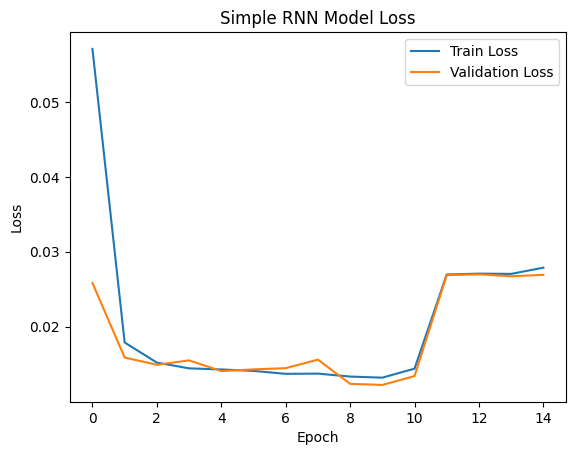

In [ ]:
plot_history(best_rnn_history, 'Simple RNN')

## LSTM

### Creating Different Model Structures

In [ ]:
from keras.layers import LSTM

# initializing the constant variables
sequence_length = 120
features_dim = 1
output_size = 1 # one seq

# initializing the hyperparameters
num_layers_list = [1, 2, 3, 5]
num_units_list = [32, 64, 128]
init_lr_list = [0.1, 0.05, 0.01, 0.001]
num_configs = 10

# Creating 10 models that have a random structure based on the parameters above
lstm_models = create_models(LSTM, num_configs,
                            num_layers_list, num_units_list, init_lr_list,
                            model_type_name='LSTM')

Model: "LSTM_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120, 128)          66560     
                                                                 
 lstm_1 (LSTM)               (None, 120, 64)           49408     
                                                                 
 lstm_2 (LSTM)               (None, 120, 32)           12416     
                                                                 
 dropout_15 (Dropout)        (None, 120, 32)           0         
                                                                 
 dense_10 (Dense)            (None, 120, 1)            33        
                                                                 
Total params: 128,417
Trainable params: 128,417
Non-trainable params: 0
_________________________________________________________________
Model: "LSTM_1"
______________________________________

### Training and Finding the Best Model

#### Training the Models

In [ ]:
# initializing the training hyper parameter lists
epochs_list = [30, 40, 50]
batch_size_list = [32, 64, 128]

lstm_models, lstm_hist_list = train_models(lstm_models,
                                           epochs_list,
                                           batch_size_list,
                                           lr_decay,
                                           'LSTM')


Training LSTM_0 

Epochs = 40
Batch Size = 128
Initial Learning Rate = 0.0010000000474974513


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/40
79/79 [==============================] - 8s 37ms/step - loss: 0.0200 - val_loss: 0.0172 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009998000674771219.
Epoch 2/40
79/79 [==============================] - 2s 23ms/step - loss: 0.0176 - val_loss: 0.0167 - lr: 9.9980e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.000999400285863144.
Epoch 3/40
79/79 [==============================] - 2s 24ms/step - loss: 0.0171 - val_loss: 0.0162 - lr: 9.9940e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.000998801174853121.
Epoch 4/40
79/79 [==============================] - 2s 24ms/step - loss: 0.0167 - val_loss: 0.0156 - lr: 9.9880e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0009980034382051895.
Epoch 5/40
79/79 [=============================

In [ ]:
# saving the models's history
save_history(lstm_models, lstm_hist_list, 'LSTM')

#### Finding the best model

In [ ]:
# getting the best lstm
best_lstm = best_model(lstm_models)

### Training on All Training Data

Since the best model is found on a sample of 10000 of the training data. Now the model is trained on the whole training dataset

In [ ]:
# creating an untrained clone of the model
best_lstm = clone(best_lstm)

Model: "LSTM_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120, 128)          66560     
                                                                 
 lstm_1 (LSTM)               (None, 120, 64)           49408     
                                                                 
 lstm_2 (LSTM)               (None, 120, 32)           12416     
                                                                 
 dropout_15 (Dropout)        (None, 120, 32)           0         
                                                                 
 dense_10 (Dense)            (None, 120, 1)            33        
                                                                 
Total params: 128,417
Trainable params: 128,417
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# these hyperparameters are the same that were initialized during the validation process
epochs = 40
batch_size = 416

# training the model
best_lstm, best_lstm_history = best_model_train(best_lstm, epochs, batch_size, 'LSTM', 'best_lstm')


Training best_lstm 

Epochs = 40
Batch Size = 416
Initial Learning Rate = 0.009999999776482582


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/40
85/85 [==============================] - 8s 46ms/step - loss: 0.0230 - val_loss: 0.0162 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009980019764048643.
Epoch 2/40
85/85 [==============================] - 3s 34ms/step - loss: 0.0157 - val_loss: 0.0152 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009940259208433621.
Epoch 3/40
85/85 [==============================] - 3s 34ms/step - loss: 0.0143 - val_loss: 0.0134 - lr: 0.0099

Epoch 4: LearningRateScheduler setting learning rate to 0.009881150349605034.
Epoch 4/40
85/85 [==============================] - 3s 33ms/step - loss: 0.0138 - val_loss: 0.0130 - lr: 0.0099

Epoch 5: LearningRateScheduler setting learning rate to 0.00980334819112968.
Epoch 5/40
85/85 [==============================] - 3s 33ms/s

### Plotting Loss

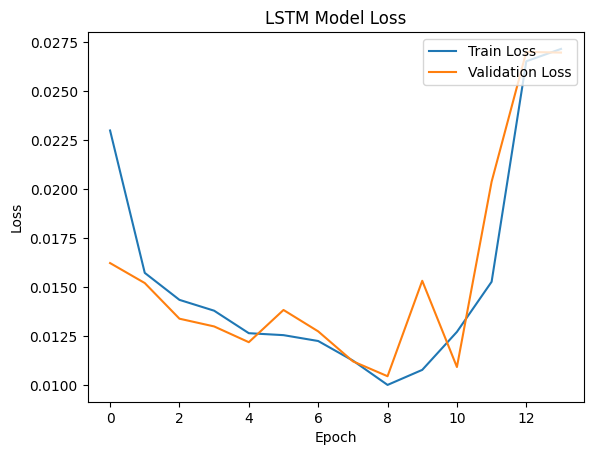

In [ ]:
plot_history(best_lstm_history, 'LSTM')

## GRU

### Creating Different Model Structures

In [ ]:
from keras.layers import GRU

# initializing the constant variables
sequence_length = 120
features_dim = 1
output_size = 1

# initializing the hyperparameters
num_layers_list = [1, 2, 3, 4]
num_units_list = [32, 64, 96]
init_lr_list = [0.1, 0.05, 0.01, 0.001]
num_configs = 10

# Creating 10 models that have a random structure based on the parameters above
gru_models = create_models(GRU, num_configs,
                           num_layers_list, num_units_list,
                           init_lr_list,
                           model_type_name='GRU')

Model: "GRU_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_20 (GRU)                (None, 120, 32)           3360      
                                                                 
 gru_21 (GRU)                (None, 120, 32)           6336      
                                                                 
 gru_22 (GRU)                (None, 120, 64)           18816     
                                                                 
 dropout_26 (Dropout)        (None, 120, 64)           0         
                                                                 
 dense_30 (Dense)            (None, 120, 1)            65        
                                                                 
Total params: 28,577
Trainable params: 28,577
Non-trainable params: 0
_________________________________________________________________
Model: "GRU_1"
__________________________________________

### Training and Finding the Best Model

#### Training the models

In [ ]:
# initializing the training hyper parameter lists
epochs_list = [30, 40, 50]
batch_size_list = [32, 64, 96]

gru_models, gru_hist_list = train_models(gru_models,
                                     epochs_list,
                                     batch_size_list,
                                     lr_decay,
                                     'GRU')


Training GRU_0 

Epochs = 50
Batch Size = 32
Initial Learning Rate = 0.05000000074505806


Epoch 1: LearningRateScheduler setting learning rate to 0.05000000074505806.
Epoch 1/50
313/313 [==============================] - 10s 21ms/step - loss: 0.0329 - val_loss: 0.0134 - lr: 0.0500

Epoch 2: LearningRateScheduler setting learning rate to 0.049502492417726564.
Epoch 2/50
313/313 [==============================] - 6s 18ms/step - loss: 0.1025 - val_loss: 0.0422 - lr: 0.0495

Epoch 3: LearningRateScheduler setting learning rate to 0.04853193398593045.
Epoch 3/50
313/313 [==============================] - 5s 17ms/step - loss: 0.0320 - val_loss: 0.0312 - lr: 0.0485

Epoch 4: LearningRateScheduler setting learning rate to 0.04713910287472031.
Epoch 4/50
313/313 [==============================] - 5s 17ms/step - loss: 0.0340 - val_loss: 0.0475 - lr: 0.0471

Epoch 5: LearningRateScheduler setting learning rate to 0.045394530136664744.
Epoch 5/50
313/313 [==============================] - 5s 18m

In [ ]:
save_history(gru_models, gru_hist_list, 'GRU')

#### Finding the best model

In [ ]:
# getting the best gru
best_gru = best_model(gru_models)

### Training on All Training Data

Since the best model is found on a sample of 10000 of the training data. Now the model is trained on the whole training dataset

In [ ]:
# creating an untrained clone of the model
best_gru = clone(best_gru)

Model: "GRU_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_23 (GRU)                (None, 120, 32)           3360      
                                                                 
 gru_24 (GRU)                (None, 120, 96)           37440     
                                                                 
 gru_25 (GRU)                (None, 120, 64)           31104     
                                                                 
 gru_26 (GRU)                (None, 120, 32)           9408      
                                                                 
 dropout_27 (Dropout)        (None, 120, 32)           0         
                                                                 
 dense_31 (Dense)            (None, 120, 1)            33        
                                                                 
Total params: 81,345
Trainable params: 81,345
Non-trainable p

In [ ]:
# these parameters are the same that were initialized during the validation process
epochs = 50
batch_size = 320

# training the model
best_gru, best_gru_history = best_model_train(best_gru, epochs, batch_size, 'GRU', 'best_gru')


Training best_gru 

Epochs = 50
Batch Size = 320
Initial Learning Rate = 0.009999999776482582


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/50
110/110 [==============================] - 9s 38ms/step - loss: 0.0215 - val_loss: 0.0150 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009980019764048643.
Epoch 2/50
110/110 [==============================] - 3s 27ms/step - loss: 0.0152 - val_loss: 0.0134 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009940259208433621.
Epoch 3/50
110/110 [==============================] - 3s 27ms/step - loss: 0.0139 - val_loss: 0.0114 - lr: 0.0099

Epoch 4: LearningRateScheduler setting learning rate to 0.009881150349605034.
Epoch 4/50
110/110 [==============================] - 3s 28ms/step - loss: 0.0127 - val_loss: 0.0114 - lr: 0.0099

Epoch 5: LearningRateScheduler setting learning rate to 0.00980334819112968.
Epoch 5/50
110/110 [==============================] - 

### Plotting Loss

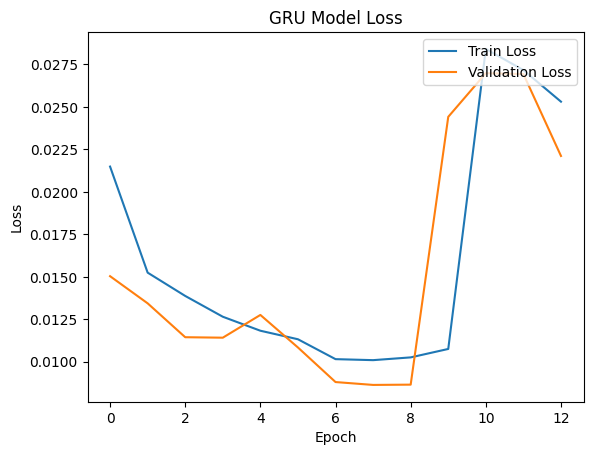

In [ ]:
plot_history(best_gru_history, 'GRU')

## Load Models (Optional)

In [9]:
from keras.models import load_model
import random
import matplotlib.pyplot as plt

best_gru = load_model('/content/drive/MyDrive/Data/MSc_DL/result_files/model_files/GRU/best_model/best_gru.h5')
best_lstm = load_model('/content/drive/MyDrive/Data/MSc_DL/result_files/model_files/LSTM/best_model/best_lstm.h5')
best_rnn = load_model('/content/drive/MyDrive/Data/MSc_DL/result_files/model_files/simple_RNN/best_model/best_rnn.h5')

## Predictions

In [10]:
# denormalizing the true values after the extra dimension is removed
y_train = np.squeeze(y_train) * app_data_kW
y_test = np.squeeze(y_test) * app_data_kW

### Simple RNN

In [60]:
# making predictions on the test and training set
y_test_pred = best_rnn.predict(X_test)
y_train_pred = best_rnn.predict(X_train)

1094/1094 [==============================] - 30s 27ms/step


In [61]:
# denormalizing the predictions for training and test set
# after the extra dimension is removed
y_test_pred = np.squeeze(y_test_pred) * app_data_kW
y_train_pred = np.squeeze(y_train_pred) * app_data_kW

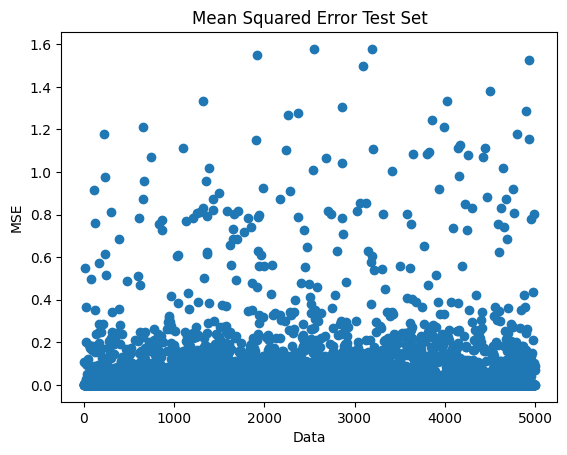

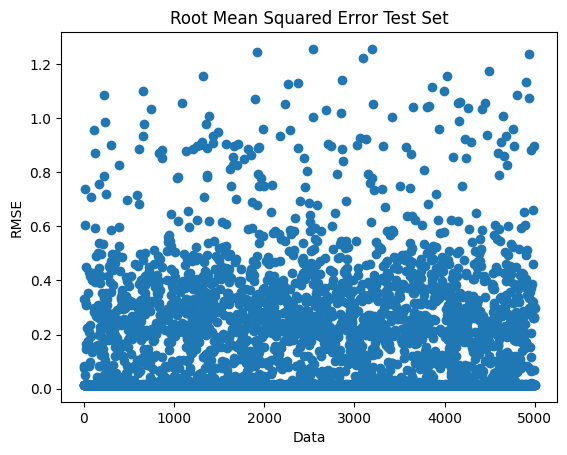

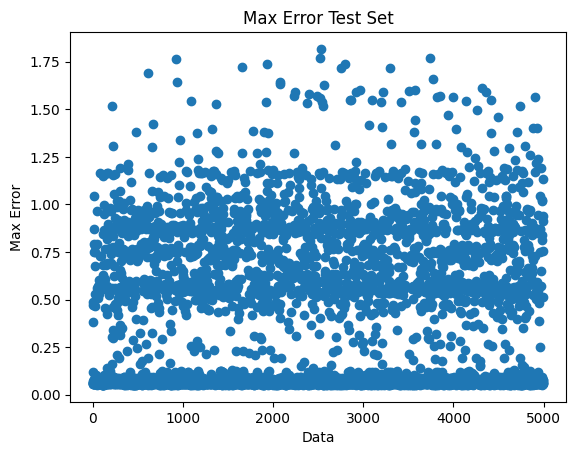

In [62]:
evaluate(y_test, y_test_pred, 'Test Set', 'RNN')

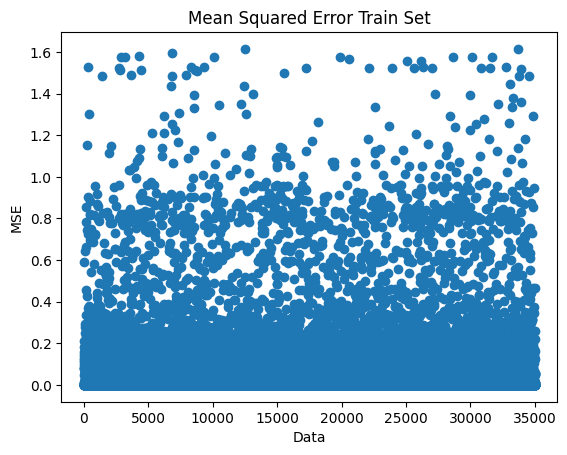

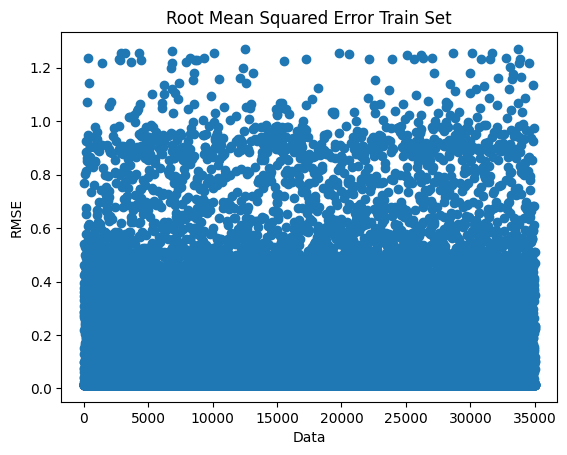

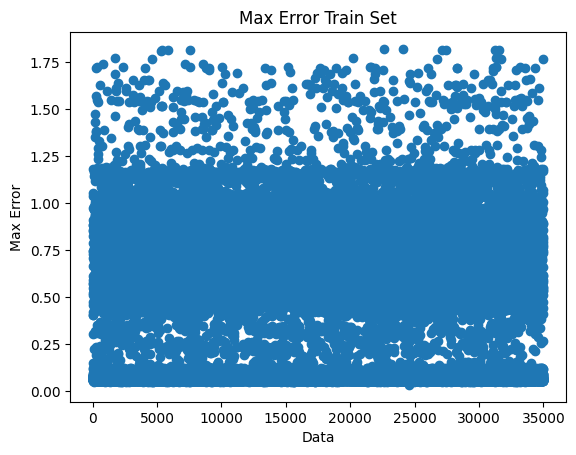

In [63]:
evaluate(y_train, y_train_pred, 'Train Set', 'RNN')

In [53]:
# getting all indexes of rows where the the machine is active and inactive respectively
active_rows = np.nonzero(np.any(y_test != 0, axis=1))[0]
inactive_rows = np.where(np.all(y_test == 0, axis=1))[0]

# picking 2 random rows where the machine is active and inactive respectively
idx1_on, idx2_on = random.choices([i for i in active_rows], k=2)
idx1_off, idx2_off = random.choices([i for i in inactive_rows], k=2)

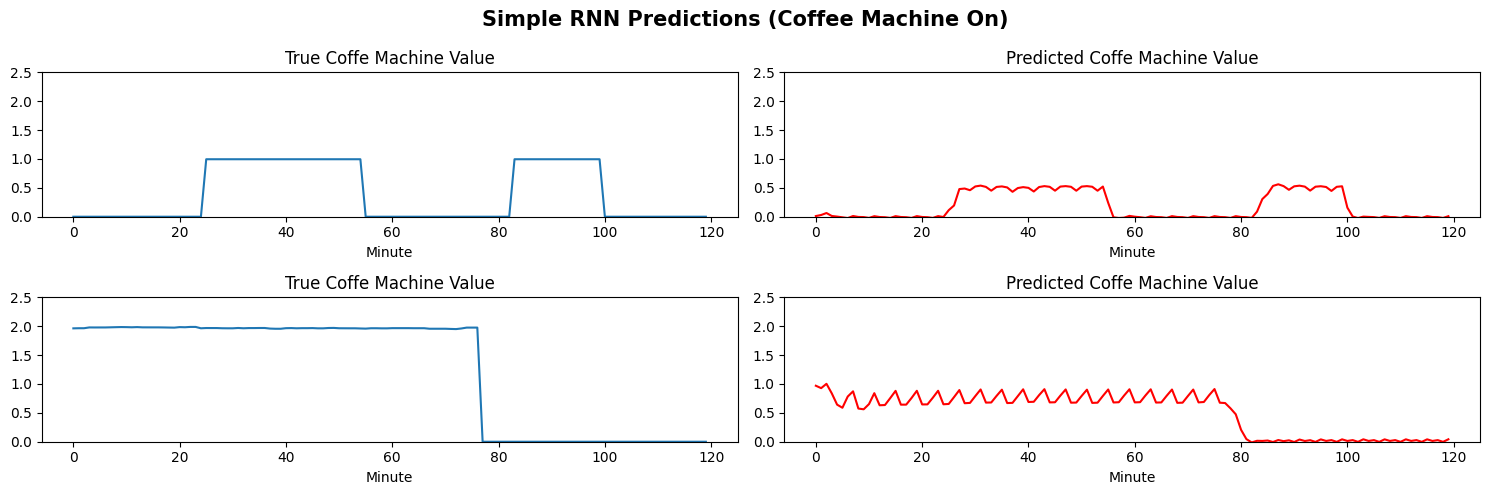

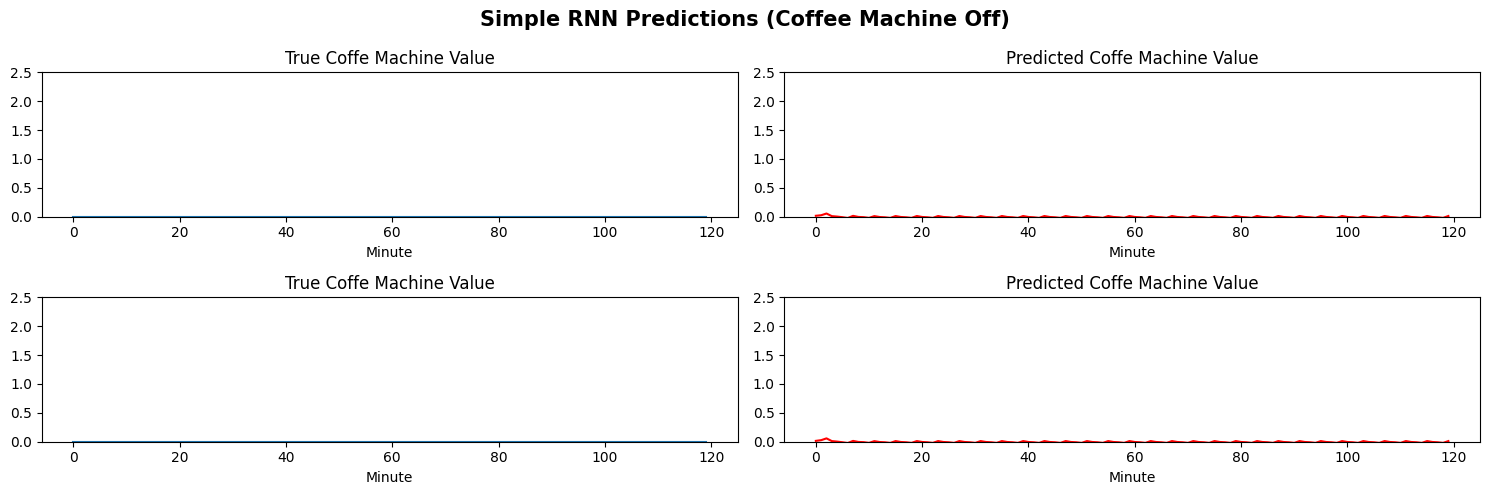

In [64]:
plot_preds('Simple RNN', y_test, y_test_pred, idx1_on, idx2_on,
           idx1_off, idx2_off)

### LSTM

In [65]:
# making predictions on the test and training set
y_test_pred = best_lstm.predict(X_test)
y_train_pred = best_lstm.predict(X_train)

1094/1094 [==============================] - 88s 80ms/step


In [66]:
# denormalizing the predictions and the true values for training set
# after the extra dimension is removed
y_test_pred = np.squeeze(y_test_pred) * app_data_kW
y_train_pred = np.squeeze(y_train_pred) * app_data_kW

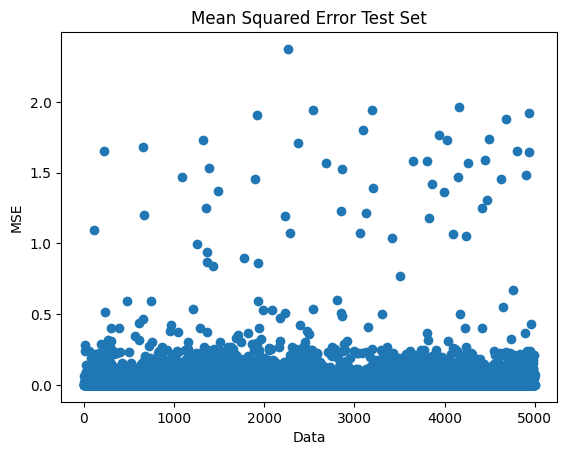

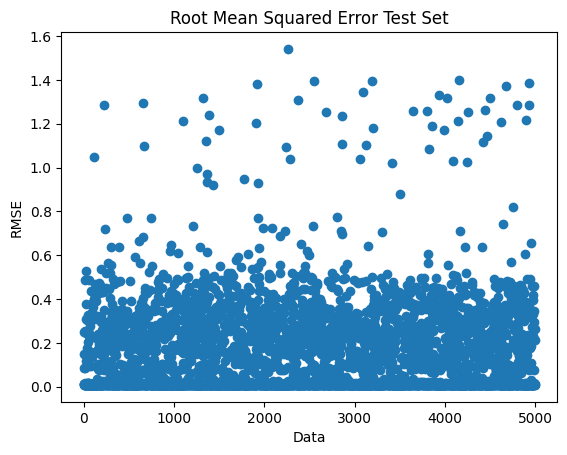

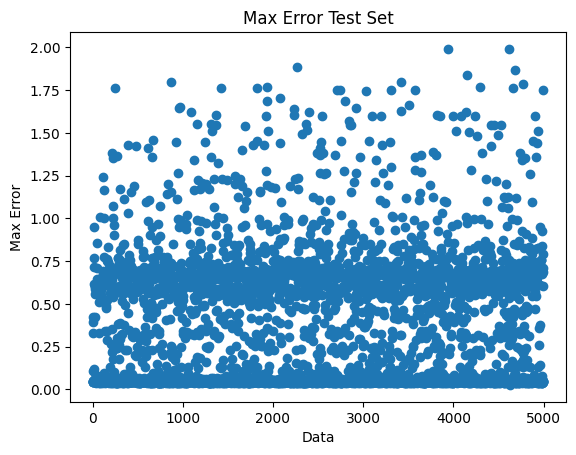

In [67]:
evaluate(y_test, y_test_pred, 'Test Set', 'LSTM')

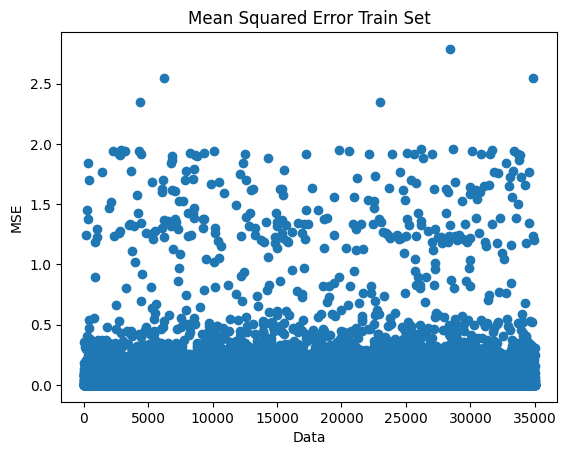

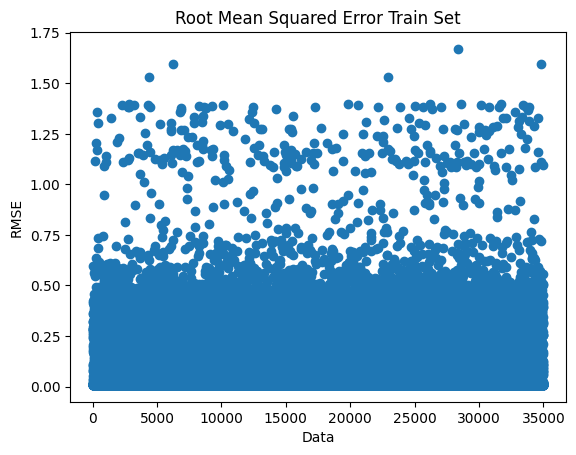

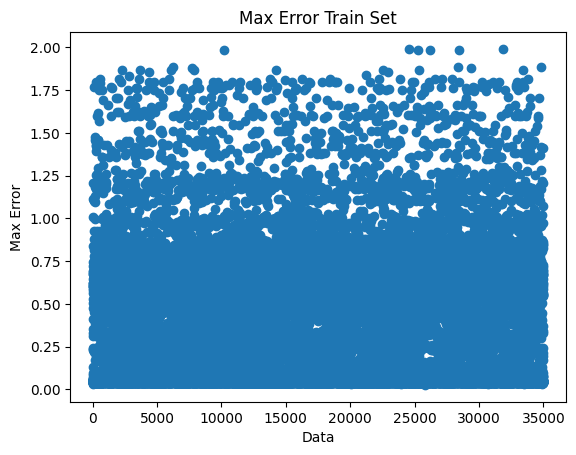

In [68]:
evaluate(y_train, y_train_pred, 'Train Set', 'LSTM')

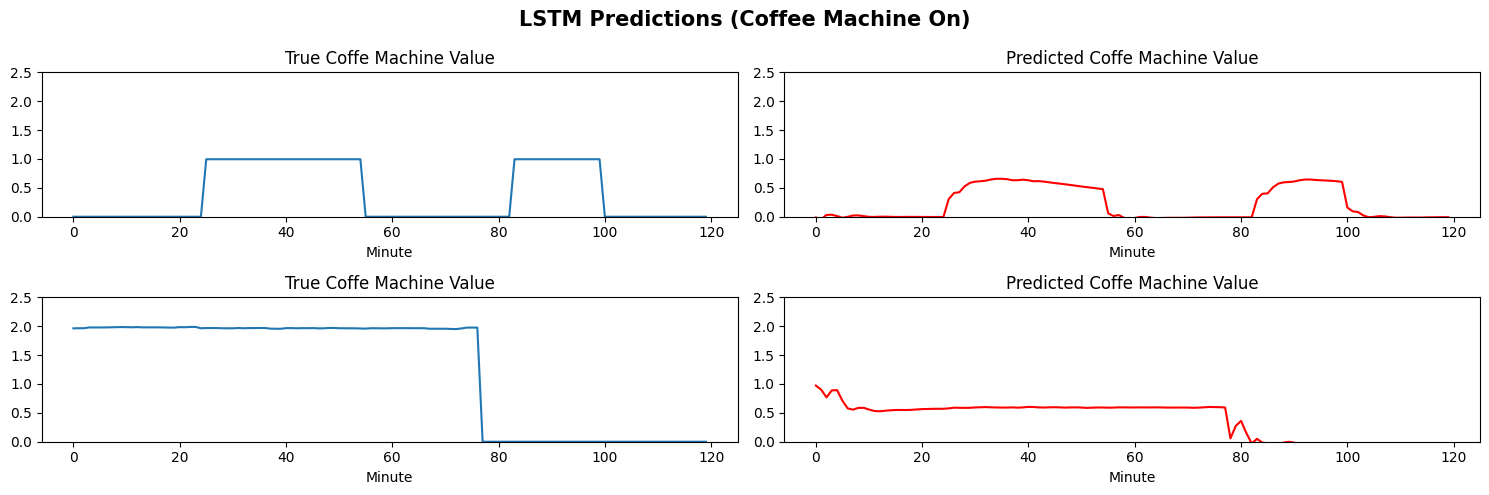

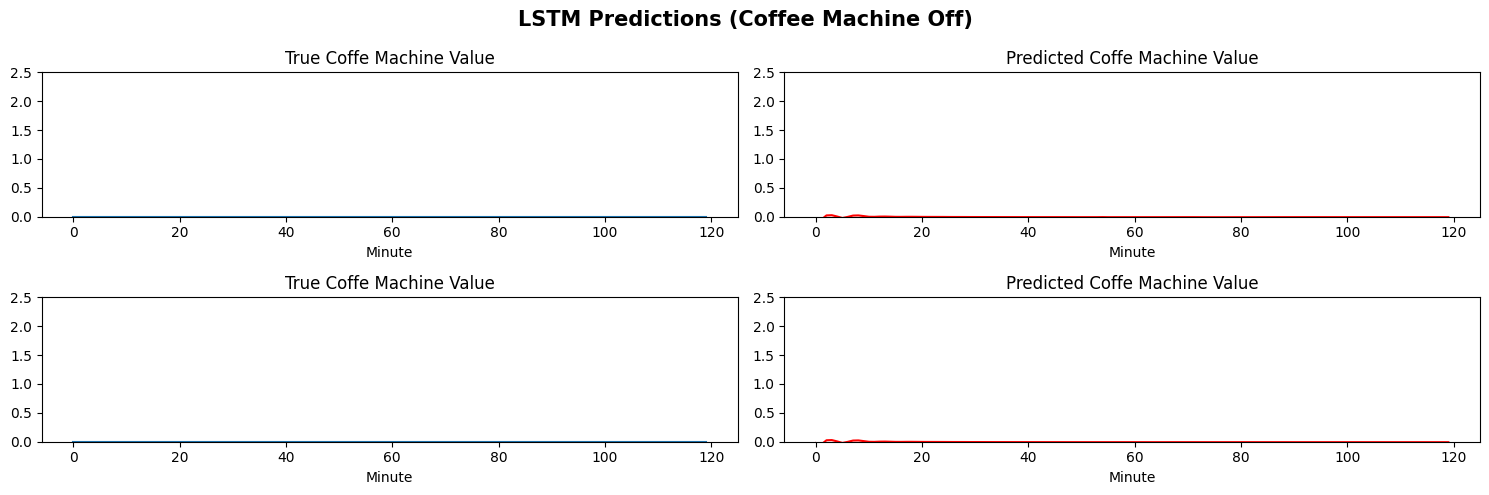

In [69]:
plot_preds('LSTM', y_test, y_test_pred, idx1_on, idx2_on,
           idx1_off, idx2_off)

### GRU

In [70]:
# making predictions on the test and training set
y_test_pred = best_gru.predict(X_test)
y_train_pred = best_gru.predict(X_train)

1094/1094 [==============================] - 65s 59ms/step


In [71]:
# denormalizing the predictions and the true values for training set
# after the extra dimension is removed
y_test_pred = np.squeeze(y_test_pred) * app_data_kW
y_train_pred = np.squeeze(y_train_pred) * app_data_kW

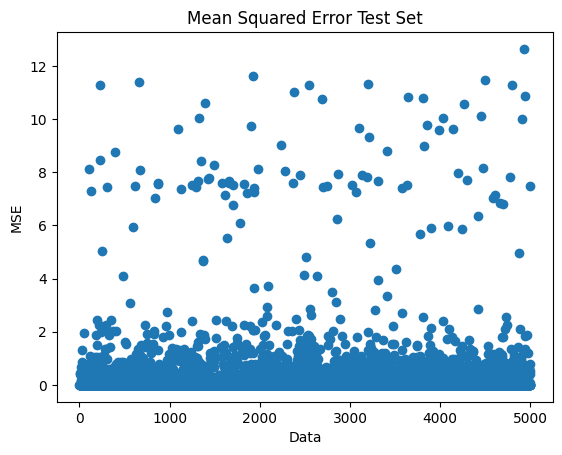

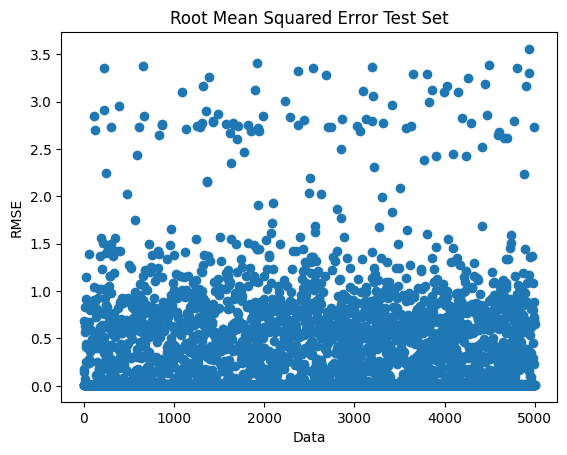

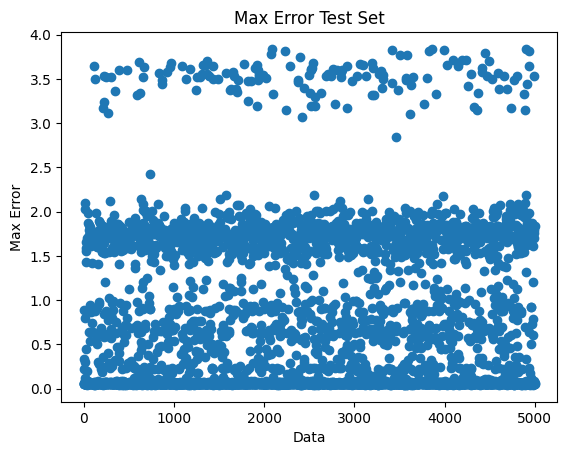

In [ ]:
evaluate(y_test, y_test_pred, 'Test Set', 'GRU')

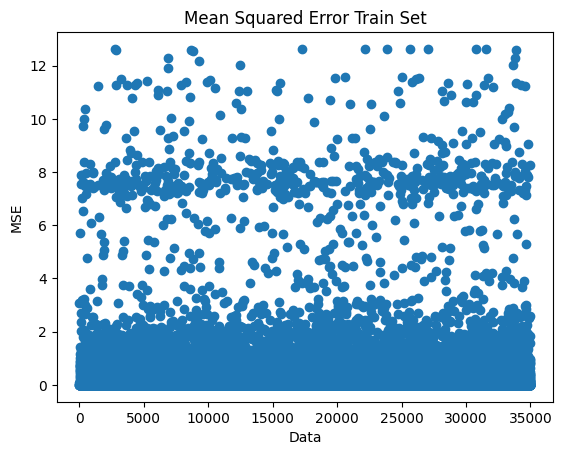

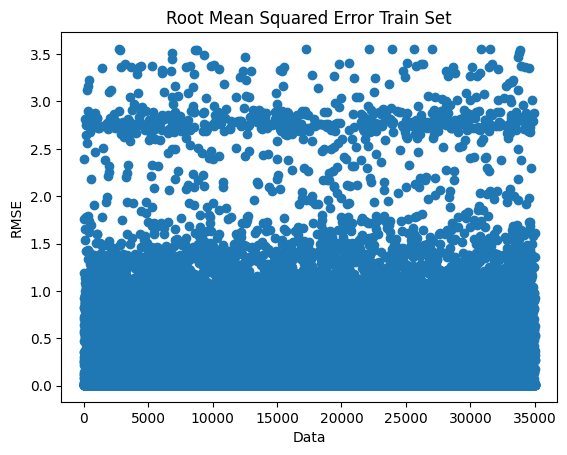

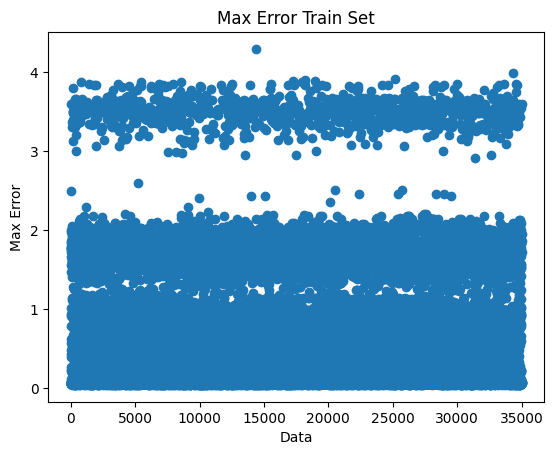

In [ ]:
evaluate(y_train, y_train_pred, 'Train Set', 'GRU')

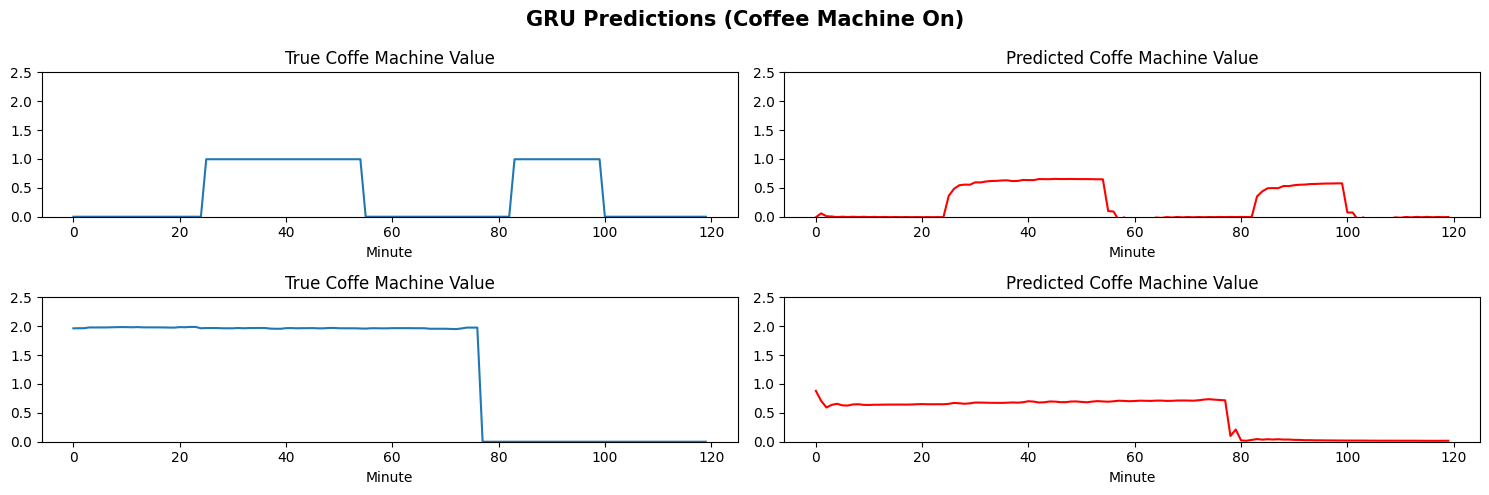

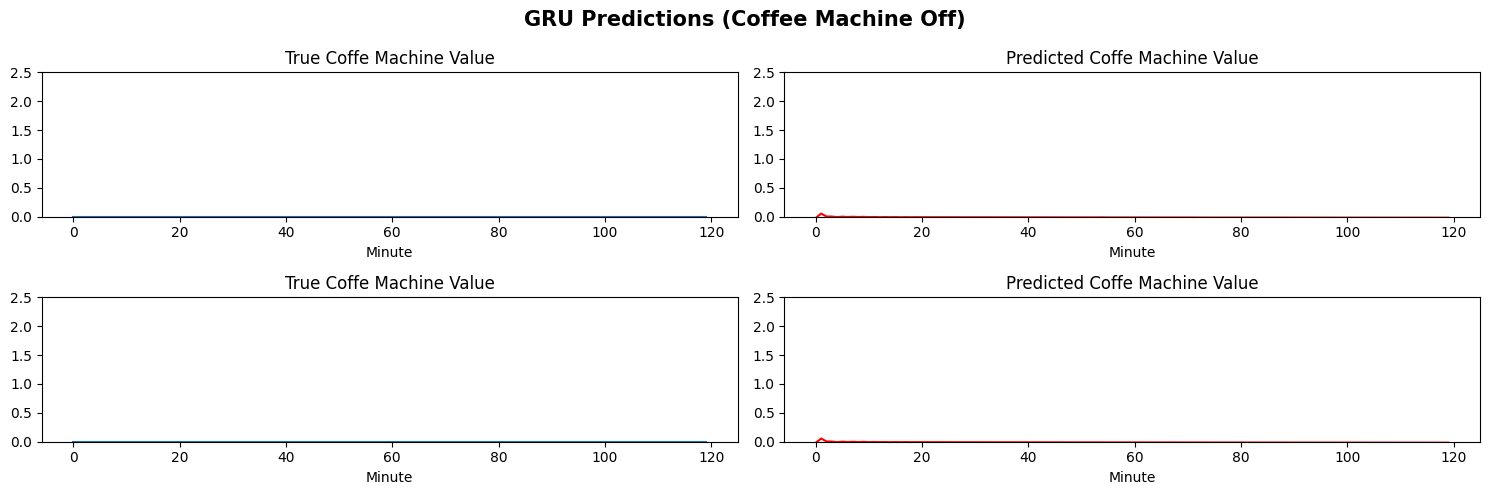

In [72]:
plot_preds('GRU', y_test, y_test_pred, idx1_on, idx2_on,
           idx1_off, idx2_off)

## Saving All Models as Plots

In [ ]:
from tensorflow import keras
from keras.utils import plot_model

# plotting the models and saving the plots
for i in range(10):
  plot_model(gru_models[i], to_file=f'/content/result_files/model_files/GRU/model_plots/gru_{i}.png',
            show_shapes=True, show_layer_names=True, show_layer_activations=True)

  plot_model(lstm_models[i], to_file=f'/content/result_files/model_files/LSTM/model_plots/lstm_{i}.png',
            show_shapes=True, show_layer_names=True, show_layer_activations=True)

  plot_model(rnn_models[i], to_file=f'/content/result_files/model_files/simple_RNN/model_plots/rnn_{i}.png',
            show_shapes=True, show_layer_names=True, show_layer_activations=True)

# also plotting the best models and saving the plots
plot_model(best_gru, to_file=f'/content/result_files/model_files/GRU/model_plots/best_gru.png',
            show_shapes=True, show_layer_names=True, show_layer_activations=True)


plot_model(best_lstm, to_file=f'/content/result_files/model_files/LSTM/model_plots/best_lstm.png',
            show_shapes=True, show_layer_names=True, show_layer_activations=True)


plot_model(best_rnn, to_file=f'/content/result_files/model_files/simple_RNN/model_plots/best_rnn.png',
            show_shapes=True, show_layer_names=True, show_layer_activations=True)